In [47]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
%pip install tqdm

from tqdm.auto import tqdm, trange

# deteministic random numbers
np.random.seed(0)
random.seed(0)

Note: you may need to restart the kernel to use updated packages.


# Linkage Synthesis Challenge Problem Advanced Code
Here we will tackle the problem with a more complex GA approach. In this notebook, rather than just optimizing the node positions, we will also optimize the connectivity of the mechanims itself. First let's just load the target curves like we did before:


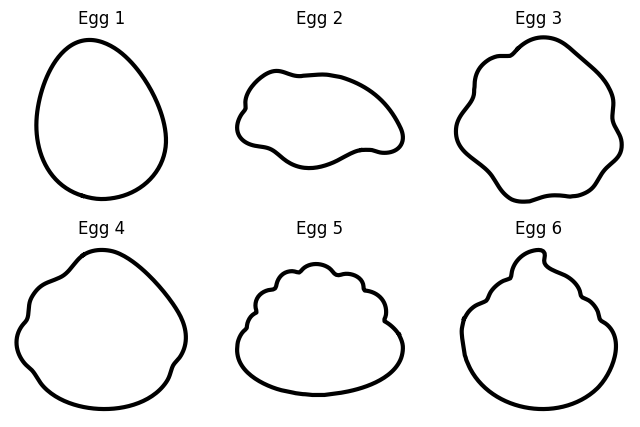

In [48]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')


## GA Full Mechanism Generation
To set up the problem within Pymoo we will have to come up with a 1D representation of the mechanisms. This code effectively just flattens the matrices and variables describing our mechanism into a single vector. However, this representation scheme is highly suboptimal, and can be improved significantly. As a demonstration, we will slightly improve upon this representation, though we encourage you to take this further. As we discussed, we can replace the edges with a connectivity matrrix. We also know the connectivity matrix is symmetric (if nodes 1 and 2 are connected nodes 2 and 1 are also connected) and has a diagonal equal to zero. To avoid making the optimization come up with the whole connectivity matrix, we will only have it come up with the upper triangular half of the matrix (not including the diagonal). This means the algorithm has to come up with $\frac{N^2-N}{2}$ 0s or 1s (i.e., booleans) to construct the adjacency matrix. We can further simplify the process by selecting a fixed motor position and having the optimization build the rest of the mechanism, removing the need for the optimization to determine the motor as well as reducing the number of 0s and 1s in the upper triangular portion by one (Saving 3 parameters in the representation). To do this we will start with the following mechanism:

<img src="https://i.ibb.co/mGywWgr/start.jpg" alt="start" border="0">

We set Node 0 to ground and Node 1 to be ordinary and the motor to be `[1,0]`. Now we know that the upper triangular portion of the connectivity matrix starts with:

<img src="https://i.ibb.co/5RqKYQN/upper-triangular-fromstart.jpg" alt="upper-triangular-fromstart" border="0">

Since we know the types of the first two nodes, we save another two parameters from the optimization. At this point we will have the same representation as we have before, but with fewer numbers and no motor or N (size of mechanisms) as we generate the mechanism to have a certain size.

<img src="https://i.ibb.co/gv2D0Y5/Optimization-Represenation.png" alt="Optimization-Represenation" border="0">

Now that we have a (slightly) improved 1D representation scheme, we will set up our problem with this many parameters. We also need to specify our constraints! Inequality constraints can be set in Pymoo (See: [constraints in pymoo](https://www.pymoo.org/constraints/index.html)) as less than or equal to zero constraints. We will set the two constraints on distance and material use in our problem.

So based on this lets get started with defining the problem in Pymoo.
<ul>
    <li>
        <code>__init__</code>: We need to differentiate between datatypes because crossover, sampling, and mutation will happen slightly differently based on datatype. As such, we create a dictionary of variables and specify which type of variable each one is.
    </li>
    <li>
<code>convert_1D_to_mech</code>: Reformats our dictionary of variables into design info that our simulator uses (edges, x0, etc.). You will need to update this function if you change the way you parameterize mechanisms. IMPORTANT: This function should not be confused for the. We have also provided a function, <code> convert_mech_to_1D </code> to do the opposite, which you may find useful. It is currently unused and is commented out.
    </li>
    <li>
<code>_evaluate</code>: Next, we define the evaluation function. We construct the mechanism using <code>convert_1D_to_mech</code>. Next, perform the same evaluations as we did in the starter notebook.
    </li>
</ul>

In [49]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

In [50]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0


Now let's try this with NSGA-II and one of the easier target curves. We will initialize with mechanisms with 6 nodes. You can test what happens if you increase this number. You should quickly discover that this naive parameterization does not perform well when initializing the GA with more complex mechanisms:

In [51]:
problem = mechanism_synthesis_optimization(target_curves[1], N=6)

algorithm = NSGA2(pop_size=100,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                #   mutation=PolynomialMutation(prob=0.9),
                  eliminate_duplicates=MixedVariableDuplicateElimination())

results = minimize(problem,
                algorithm,
                ('n_gen', 100),
                verbose=True,
                save_history=True,
                seed=0
                )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  1.359641E+01 |           INF |             - |             -
     2 |      200 |      1 |  3.8797655106 |           INF |             - |             -
     3 |      300 |      1 |  3.8797655106 |           INF |             - |             -
     4 |      400 |      1 |  3.8797655106 |           INF |             - |             -
     5 |      500 |      1 |  3.8797655106 |           INF |             - |             -
     6 |      600 |      1 |  2.5941102505 |           INF |             - |             -
     7 |      700 |      1 |  2.5941102505 |           INF |             - |             -
     8 |      800 |      1 |  2.5941102505 |           INF |             - |             -
     9 |      900 |      1 |  0.8760614395 |           INF |             - |             -
    10 |     1000 |      1 |  0.8760614395 |           INF |             - |             -

In [52]:
if results.X is None:
    print("No feasible solution found !!!!!")

No feasible solution found !!!!!


You can see that if you just run GA you will not be able to find any good solutions, even for smaller mechanisms with 6 joints! 

In the starter notebook we gave you a mechanism to initialize GA with. Now we introduce the `MechanismRandomizer` class which can help you generate random mechanisms of any size you need. Let's see how this class works (The first time you run this it will be a little slow):

In [53]:
from LINKS.Optimization import MechanismRandomizer
from LINKS.Visualization import MechanismVisualizer

In [54]:
randomizer = MechanismRandomizer(
    min_size = 6, # smalllest mechanism to sample
    max_size = 14, # largest mechanism to sample
    device='cpu')

visualizer = MechanismVisualizer()
print(randomizer)

In [55]:
random_mechanism = randomizer()

# Let's see what the output looks like (it is exactly like the submission format)
print(random_mechanism)

{'x0': array([[0.00672208, 0.30434308],
       [0.09444426, 0.32314703],
       [0.71814523, 0.53270468],
       [0.46979491, 0.738745  ],
       [0.64405118, 0.82102564],
       [0.73955896, 0.36019162],
       [0.04767657, 0.5210782 ],
       [0.74297543, 0.66217877],
       [0.15670085, 0.94952192],
       [0.18760073, 0.15436882],
       [0.17956982, 0.24588698],
       [0.57262338, 0.83823424],
       [0.32943584, 0.88550956],
       [0.25987139, 0.72984461]]), 'edges': array([[ 0,  1],
       [ 1,  3],
       [ 2,  3],
       [ 3,  4],
       [ 2,  4],
       [ 1,  5],
       [ 4,  5],
       [ 4,  6],
       [ 5,  6],
       [ 1,  7],
       [ 2,  7],
       [ 6,  8],
       [ 5,  8],
       [ 3,  9],
       [ 4,  9],
       [ 7, 10],
       [ 8, 10],
       [ 9, 12],
       [11, 12],
       [12, 13],
       [10, 13]]), 'fixed_joints': array([ 0,  2, 11]), 'motor': array([0, 1])}


<Axes: >

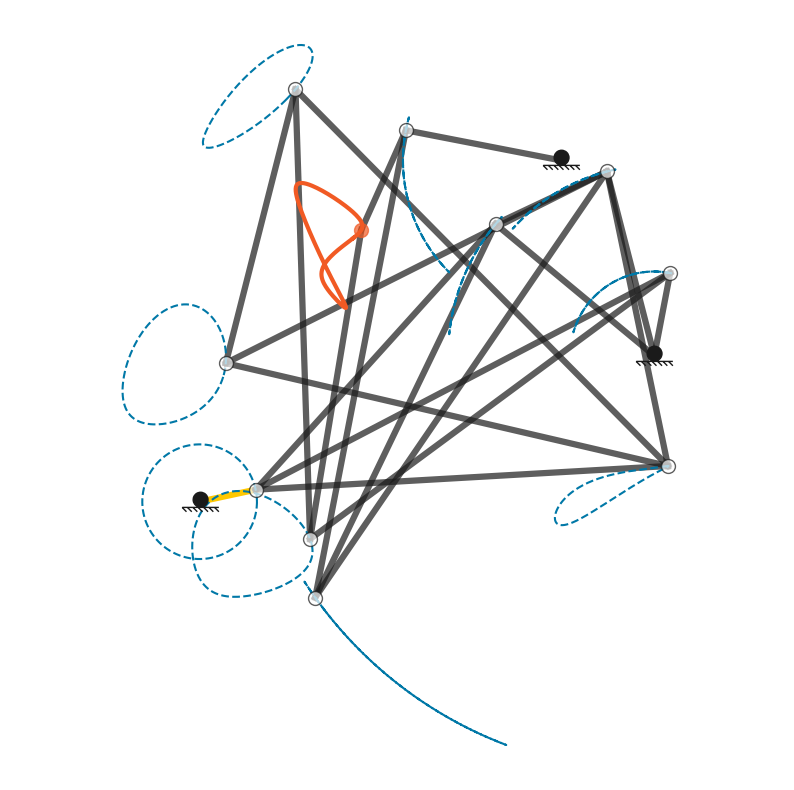

In [56]:
# Visualize the random mechanism
visualizer(**random_mechanism)

In [57]:
# Now let's generate 100 mechanisms of size 7 and initilize a population for optimization
mechanisms = [randomizer(n=7) for _ in trange(100)]



  0%|          | 0/100 [00:00<?, ?it/s]

In [58]:
problem = mechanism_synthesis_optimization(target_curves[1], N=7)

initial_population = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

class sample_from_random(Sampling):
        def _do(self, problem, n_samples, **kwargs):
                return np.array([initial_population[i%len(initial_population)] for i in range(n_samples)])

F = problem.evaluate(np.array(initial_population))[0]
print(f'Best Distance Performance In random population: {F[:,0].min()}')
print(f'Best Material Performance In random population: {F[:,1].min()}')

Best Distance Performance In random population: 0.8713314533233643
Best Material Performance In random population: 4.422967433929443


CHAT SITT FORSLAG NR 2


In [59]:
import numpy as np

def _scalar(v):  # robustly turn array/scalar-like into float
    a = np.asarray(v)
    return float(a.ravel()[0]) if a.size else 0.0

def normalize_candidate(x, N):
    """Fill any missing fields expected by convert_1D_to_mech."""
    x = dict(x)  # copy so we can edit

    # 1) target
    x.setdefault("target", N-1)
    x["target"] = int(_scalar(x["target"])) % N

    # 2) connectivity: ensure all Cj_i exist (default 0); keep any provided
    for i in range(N):
        for j in range(i):
            x.setdefault(f"C{j}_{i}", 0)
    # (function already forces C0_1 = 1 internally)

    # 3) fixed nodes: if none provided, pin 0 and 1
    has_fixed = any(bool(x.get(f"fixed_nodes{i}", False)) for i in range(N))
    if not has_fixed:
        for i in range(N):
            x[f"fixed_nodes{i}"] = bool(i in (0, 1))
    else:
        # normalize to bools
        for i in range(N):
            if f"fixed_nodes{i}" in x:
                x[f"fixed_nodes{i}"] = bool(x[f"fixed_nodes{i}"])

    # 4) positions: ensure X0<i> keys exist
    has_X0 = any(k.startswith("X0") for k in x)
    if not has_X0:
        # try from x<i>/y<i> pairs
        ok = True
        coords = []
        for k in range(N):
            if f"x{k}" in x and f"y{k}" in x:
                coords += [_scalar(x[f"x{k}"]), _scalar(x[f"y{k}"])]
            else:
                ok = False; break
        if ok:
            for k, val in enumerate(coords):
                x[f"X0{k}"] = float(val)
        else:
            # last resort: make a small centered layout in bounds
            base = np.clip(np.random.normal(2.5, 0.8, size=2*N), 0.2, 4.8)
            for k, val in enumerate(base):
                x[f"X0{k}"] = float(val)

    return x


In [60]:
# === Newton–CG distance minimization over random populations, per target curve ===
import numpy as np
from tqdm import trange
from scipy.optimize import minimize
from LINKS.Optimization import DifferentiableTools

N_JOINTS    = 5
POP_SIZE    = 50
NCG_MAXITER = 50

# ---------------- gradient tools (compile once) ----------------
gradient_tools = DifferentiableTools(device="cpu")  # or "mps" if you set up jax-metal
gradient_tools.compile()

# ---------------- helpers ----------------
def _scalar(v):
    a = np.asarray(v)
    return float(a.ravel()[0]) if a.size else 0.0

def normalize_candidate(x, N):
    """Ensure the dict has all keys expected by convert_1D_to_mech."""
    x = dict(x)  # copy

    # 1) target
    x.setdefault("target", N-1)
    x["target"] = int(np.asarray(x["target"]).ravel()[0]) % N

    # 2) connectivity: default to a simple chain 0-1-2-...-(N-1)
    for i in range(N):
        for j in range(i):
            key = f"C{j}_{i}"
            if key not in x:
                x[key] = 1 if j == i-1 else 0   # <-- chain by default

    # 3) fixed nodes – pin 0 and 1 if none provided
    any_fixed = any(bool(x.get(f"fixed_nodes{i}", False)) for i in range(N))
    if not any_fixed:
        for i in range(N):
            x[f"fixed_nodes{i}"] = bool(i in (0, 1))
    else:
        for i in range(N):
            if f"fixed_nodes{i}" in x:
                x[f"fixed_nodes{i}"] = bool(x[f"fixed_nodes{i}"])

    # 4) positions X0<k>
    has_X0 = any(k.startswith("X0") for k in x)
    if not has_X0:
        ok = True
        coords = []
        for k in range(N):
            if f"x{k}" in x and f"y{k}" in x:
                coords += [float(np.asarray(x[f"x{k}"]).ravel()[0]),
                           float(np.asarray(x[f"y{k}"]).ravel()[0])]
            else:
                ok = False; break
        if ok:
            for k, val in enumerate(coords):
                x[f"X0{k}"] = float(val)
        else:
            base = np.clip(np.random.normal(2.5, 0.8, size=2*N), 0.2, 4.8)
            for k, val in enumerate(base):
                x[f"X0{k}"] = float(val)
    return x


def project_and_pin(X, x0, fixed_joints):
    """Clamp to [0,5] and keep fixed joints exactly at x0."""
    X = np.clip(np.asarray(X, float).reshape(x0.shape), 0.0, 5.0)
    X[fixed_joints] = x0[fixed_joints]
    return X

def make_fun_and_jac(x0, edges, fixed_joints, motor, target_curve, target_idx):
    N = x0.shape[0]
    def fun(v):
        X = project_and_pin(v.reshape(N, 2), x0, fixed_joints)
        dist, mat, dist_g, mat_g = gradient_tools(
            X, edges, fixed_joints, motor, target_curve, target_idx=target_idx
        )
        return float(np.asarray(dist))
    def jac(v):
        X = project_and_pin(v.reshape(N, 2), x0, fixed_joints)
        dist, mat, dist_g, mat_g = gradient_tools(
            X, edges, fixed_joints, motor, target_curve, target_idx=target_idx
        )
        g = np.asarray(dist_g, float)           # (N,2)
        return g.ravel()                        # 1D, length 2*N
    return fun, jac

def distance_only(x_nodes, edges, fixed_joints, motor, target_curve, target_idx):
    """Convenience for measuring distance at node array."""
    dist, mat, dist_g, mat_g = gradient_tools(
        x_nodes, edges, fixed_joints, motor, target_curve, target_idx=target_idx
    )
    return float(np.asarray(dist))

# ---------------- main loop ----------------
per_curve = []
all_improvements = []

for ci, target_curve in enumerate(target_curves):
    # build the per-curve problem
    problem = mechanism_synthesis_optimization(target_curve, N=N_JOINTS)

    # fresh random population for THIS curve (dicts)
    population = [randomizer(n=N_JOINTS) for _ in trange(POP_SIZE, desc=f"curve {ci:02d}")]

    best_final = np.inf
    improvements = []
    valid = 0

    for cand in population:
        xi = normalize_candidate(cand, N_JOINTS)
        # decode this candidate into arrays the kernel expects
        x0, edges, fixed_joints, motor, target_idx = problem.convert_1D_to_mech(xi)

        # initial distance
        d0 = distance_only(x0, edges, fixed_joints, motor, target_curve, target_idx)
        if not np.isfinite(d0):
            continue

        # Newton–CG: create fun/jac bound to THIS mechanism
        fun, jac = make_fun_and_jac(x0, edges, fixed_joints, motor, target_curve, target_idx)
        v0 = x0.reshape(-1)

        res = minimize(fun, v0, method="Newton-CG", jac=jac,
                       options={"maxiter": NCG_MAXITER, "xtol": 1e-6, "disp": False})

        x_fin = project_and_pin(res.x.reshape(x0.shape), x0, fixed_joints)
        d1 = distance_only(x_fin, edges, fixed_joints, motor, target_curve, target_idx)
        if not np.isfinite(d1):
            continue

        valid += 1
        improvements.append(d0 - d1)
        best_final = min(best_final, d1)

    # per-curve summary
    if valid == 0:
        per_curve.append({
            "target_index": ci, "population": POP_SIZE, "valid": 0,
            "best_final_distance": float("inf"),
            "avg_improvement": float("nan"),
            "median_improvement": float("nan"),
            "ncg_maxiter": NCG_MAXITER,
        })
        print(f"[curve {ci:02d}] valid=0/{POP_SIZE} (all invalid)")
    else:
        per_curve.append({
            "target_index": ci, "population": POP_SIZE, "valid": valid,
            "best_final_distance": float(best_final),
            "avg_improvement": float(np.mean(improvements)),
            "median_improvement": float(np.median(improvements)),
            "ncg_maxiter": NCG_MAXITER,
        })
        all_improvements.extend(improvements)
        print(f"[curve {ci:02d}] valid={valid}/{POP_SIZE}  "
              f"best_final={best_final:.6f}  avg_improve={np.mean(improvements):.6f}")

# overall summary
print("\n=== Overall ===")
if all_improvements:
    print(f"num_targets: {len(target_curves)}")
    print(f"global_avg_improvement: {np.mean(all_improvements):.6f}")
    print(f"global_median_improvement: {np.median(all_improvements):.6f}")
else:
    print(f"num_targets: {len(target_curves)}  (no valid candidates)")


curve 00: 100%|██████████| 50/50 [00:00<00:00, 66.58it/s]


[curve 00] valid=0/50 (all invalid)


curve 01: 100%|██████████| 50/50 [00:00<00:00, 72.87it/s]


[curve 01] valid=0/50 (all invalid)


curve 02: 100%|██████████| 50/50 [00:00<00:00, 74.37it/s]


[curve 02] valid=0/50 (all invalid)


curve 03: 100%|██████████| 50/50 [00:00<00:00, 74.26it/s]


[curve 03] valid=0/50 (all invalid)


curve 04: 100%|██████████| 50/50 [00:00<00:00, 74.44it/s]


[curve 04] valid=0/50 (all invalid)


curve 05: 100%|██████████| 50/50 [00:00<00:00, 74.23it/s]


[curve 05] valid=0/50 (all invalid)

=== Overall ===
num_targets: 6  (no valid candidates)


MITT DUMME FORSLAG

In [61]:
#her skal jeg kode noe smart!!!!!!!!!!!!!!!!!!!!

from scipy.optimize import minimize 


problem = mechanism_synthesis_optimization(target_curves[1], N=5)




gradient_tools = DifferentiableTools(device="cpu")  # or "mps" if you set up jax-metal
gradient_tools.compile()


def distance_and_grad(x, target_curve):
    """Return (distance, ∂distance/∂x) using the provided tools."""
    dist, mat, dist_g, mat_g = gradient_tools(
        x, edges, fixed_joints, motor, target_curve, target_idx=None
    )
    # Make sure types are numpy
    dist = float(np.asarray(dist))                 # scalar
    grad = np.asarray(dist_g, dtype=float)         # array, not list
    return dist, grad



 #is this setting up a GA problem?



for i, target_curve in enumerate(target_curves):

    #make a random population of 50 mechanism with 5
    random_population = [randomizer(n=5) for _ in trange(50)]
    best_final_dist = np.inf
    best_x = None
    improvements = []

    for x in random_population: #iterateing through the random population
        
        xi = normalize_candidate(x, 5) 
        #evaluate the distance and material before optimization
        x0, edges, fixed_joints, motor, target_idx = problem.convert_1D_to_mech(xi) #converting to nodes
        
        distance0, material0 = PROBLEM_TOOLS(x0, edges,fixed_joints,motor, target_curve,target_idx=target_idx)
        before = np.array([distance0, material0])

        dist, mat, dist_g, mat_g = gradient_tools(x0, edges, fixed_joints, motor, target_curve, target_idx=None)

 #do the optimization here NEWTON CG METHOD THIS TIME
        res = minimize(dist, x0.reshape(-1), method="Newton-CG", jac=dist_g,
                   options={"maxiter": 200, "xtol": 1e-6, "disp": False})
        


       
        #need to find the objective function to minimize here
        d0,g0= distance_and_grad(x, target_curve)
        





        d1,g1= distance_and_grad(x, target_curve)
        improvements.append(d0 - d1)
        if d1 < best_final_dist:
            best_final_dist = d1
            best_x = x_fin
        
        
        
        
        #---------
        

        

        #evaluate the distance and material after and print the difference or something

        distance1, material1 = PROBLEM_TOOLS(x0, edges,fixed_joints,motor, target_curve,target_idx=target_idx)
        after = np.array([distance1, material1])
        difference_distance = after[distance0]-before[distance1]
        
        difference_distance=d1-d0
        print(difference_distance)



 



100%|██████████| 50/50 [00:00<00:00, 68.31it/s]


ValueError: Jacobian is required for Newton-CG method

In [62]:
# === Robust Adam-on-distance experiment over all target curves ===
# Requires: x0, edges, fixed_joints, motor, target_curves

import numpy as np
from LINKS.Optimization import DifferentiableTools

np.random.seed(0)

# -------- gradient tools --------
gradient_tools = DifferentiableTools(device="cpu")   # or "mps" with jax-metal
gradient_tools.compile()

# ---------- helpers ----------
def flat(x):   return np.asarray(x, float).reshape(-1)
def unflat(v): return np.asarray(v, float).reshape(-1, 2)

def project_and_pin(x):
    """Clamp to [0,5] and keep fixed joints exactly at x0."""
    X = unflat(x)
    X = np.clip(X, 0.0, 5.0)
    X[fixed_joints] = x0[fixed_joints]
    return X

def safe_distance_and_grad(x_nodes, target_curve):
    """
    Call the differentiable kernel, but return (inf, zeros) if something goes wrong
    or if distance/grad are non-finite. Always returns (scalar, (N,2) ndarray).
    """
    X = unflat(x_nodes)
    try:
        dist, mat, dist_g, mat_g = gradient_tools(
            X, edges, fixed_joints, motor, target_curve, target_idx=None
        )
        dist = float(np.asarray(dist))
        grad = np.asarray(dist_g, float)
        if not np.isfinite(dist) or not np.all(np.isfinite(grad)):
            return float("inf"), np.zeros_like(X)
        return dist, grad
    except Exception:
        # Any runtime issue in the kernel -> treat as invalid sample
        return float("inf"), np.zeros_like(X)

def initial_distance(x, target_curve):
    d, _ = safe_distance_and_grad(x, target_curve)
    return float(d)

def adam_distance_minimize(x_start, target_curve, steps=400, lr=1e-2,
                           beta1=0.9, beta2=0.999, eps=1e-8):
    """Adam on distance only, with projection & fixed-joint pinning. Returns (x_final, dist)."""
    v = flat(project_and_pin(x_start)).copy()
    m = np.zeros_like(v)   # first moment
    s = np.zeros_like(v)   # second moment
    for t in range(1, steps+1):
        L, g = safe_distance_and_grad(v, target_curve)  # v is flat; safe_* accepts flat
        if not np.isfinite(L):
            return unflat(v), float("inf")              # bail on invalid step
        g = flat(g)                                    # ravel gradient
        m = beta1*m + (1-beta1)*g
        s = beta2*s + (1-beta2)*(g*g)
        m_hat = m / (1 - beta1**t)
        s_hat = s / (1 - beta2**t)
        v = v - lr * m_hat / (np.sqrt(s_hat) + eps)
        v = flat(project_and_pin(v))
    x_final = unflat(v)
    final_dist, _ = safe_distance_and_grad(x_final, target_curve)
    return x_final, float(final_dist)

def jitter_around_x0(scale=0.05):
    """Make a noisy copy of x0, staying in bounds and re-pinning fixed joints."""
    x = x0 + scale * np.random.randn(*x0.shape)
    return project_and_pin(x)

# ---------- knobs ----------
NUM_RESTARTS = 10      # per target curve
ADAM_STEPS   = 400
ADAM_LR      = 1e-2
JITTER_SCALE = 0.05

# ---------- run over all target curves ----------
per_curve = []         # one summary dict per target
all_improvements = []  # improvements from every valid restart across all targets

for i, target_curve in enumerate(target_curves):
    # restarts: [x0] + jittered copies
    starts = [x0] + [jitter_around_x0(JITTER_SCALE) for _ in range(NUM_RESTARTS-1)]

    best_final_dist = np.inf
    best_x = None
    improvements = []
    valid = 0

    for x_start in starts:
        d0 = initial_distance(x_start, target_curve)
        if not np.isfinite(d0):
            continue  # skip invalid start

        x_fin, d1 = adam_distance_minimize(x_start, target_curve,
                                           steps=ADAM_STEPS, lr=ADAM_LR)
        if not np.isfinite(d1):
            continue  # skip invalid result

        valid += 1
        improvements.append(d0 - d1)
        if d1 < best_final_dist:
            best_final_dist = d1
            best_x = x_fin

    # summarize this curve
    if valid == 0:
        per_curve.append({
            "target_index": int(i),
            "valid_restarts": 0,
            "best_final_distance": float("inf"),
            "avg_improvement_over_restarts": float("nan"),
            "median_improvement_over_restarts": float("nan"),
            "num_restarts": int(NUM_RESTARTS),
        })
        print(f"[curve {i:02d}] valid=0/{NUM_RESTARTS} (all restarts invalid)")
    else:
        per_curve.append({
            "target_index": int(i),
            "valid_restarts": int(valid),
            "best_final_distance": float(best_final_dist),
            "avg_improvement_over_restarts": float(np.mean(improvements)),
            "median_improvement_over_restarts": float(np.median(improvements)),
            "num_restarts": int(NUM_RESTARTS),
        })
        all_improvements.extend(improvements)
        print(f"[curve {i:02d}] valid={valid}/{NUM_RESTARTS}  "
              f"best_final_dist={best_final_dist:.4f}  "
              f"avg_improve={np.mean(improvements):.4f}")

# ---------- overall summary ----------
if all_improvements:
    avg_all = float(np.mean(all_improvements))
    med_all = float(np.median(all_improvements))
else:
    avg_all = 0.0
    med_all = 0.0

adam_summary = {
    "algo": "Adam (distance-only)",
    "num_targets": int(len(target_curves)),
    "avg_improvement_over_all_targets": avg_all,
    "median_improvement_over_all_targets": med_all,
}
print("\n=== Adam summary ===")
for k, v in adam_summary.items():
    print(f"{k}: {v}")



[curve 00] valid=0/10 (all restarts invalid)
[curve 01] valid=0/10 (all restarts invalid)
[curve 02] valid=0/10 (all restarts invalid)
[curve 03] valid=0/10 (all restarts invalid)
[curve 04] valid=0/10 (all restarts invalid)
[curve 05] valid=0/10 (all restarts invalid)

=== Adam summary ===
algo: Adam (distance-only)
num_targets: 6
avg_improvement_over_all_targets: 0.0
median_improvement_over_all_targets: 0.0


We see that if we initialize GA with some valid samples, it is much more likely to succeed! Let's take a look at the solutions of this run:

In [63]:
from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine

In [64]:
from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

Did Not Find Solutions!!


You can use this population to make a submission:

In [65]:
from LINKS.CP import make_empty_submission, evaluate_submission

submission = make_empty_submission()

# add out population to submission
if not results.X is None:
    for i in range(results.X.shape[0]):
        if not isinstance(results.X, dict):
            x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X[i])
        else:
            x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X)
        
        mech = {
            'x0': x0_member,
            'edges': edges,
            'fixed_joints': fixed_joints,
            'motor': motor,
            'target_joint': target_idx
        }
        
        submission['Problem 2'].append(mech)

In [66]:
evaluate_submission(submission)

{'Overall Score': 0.0,
 'Score Breakdown': {'Problem 1': 0.0,
  'Problem 2': 0.0,
  'Problem 3': 0.0,
  'Problem 4': 0.0,
  'Problem 5': 0.0,
  'Problem 6': 0.0}}

You can see that GA is still not doing great with handling different mechanisms. You could adjust the initialization more, change mutation and cross-over functionality. So far however, we have not yet touched on gradient-based optimization. What if we took the solutions of GA and optimized for each of the objectives.

Now let's take the GA solutions from above and just optimize for the lowest distance. Then we will add the optimized solutions to the population we have and see how the hypervolume changes.

 **Note that if the material use exceeds 10 during this optimization the score will not change How could you address this?** 

In [67]:
from LINKS.Optimization import DifferentiableTools

In [68]:
differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs

In [69]:
# lets make a batch from our GA results
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if not results.X is None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

here is how this differentiable class works:

In [70]:
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s,
    edges,
    fixed_joints,
    motors,
    target_curves[1],
    target_idxs
)

print(materials, distances)

TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 1, indexer value Traced<float32[0]>with<DynamicJaxprTrace>

**NOTE:** Sometimes the mechanisms are close to locking, which results in gradients exploding and in these cases the `DifferentiableTools` will return inifity results. You can ignore these since the `Tools` class will still simulate them eventhough the gradients are near singular.

In [ ]:
x = x0s.copy()

step_size = 4e-4
n_steps = 1000

# keep track of which members are done optimizing
done_optimizing = np.zeros(len(x), dtype=bool)

x_last = x.copy()

for step in trange(n_steps):
    
    # get current distances, materials and gradients
    distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
        x,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )
    
    # only update members that are valid and not done optimizing
    valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    
    # if a member is invalid, revert to last step and mark as done optimizing
    for i in invalids:
        done_optimizing[i] = True
        x[i] = x_last[i]
    
    # keep a copy of last step
    x_last = x.copy()
    
    # update valid members
    for i in valids:
        if done_optimizing[i]:
            continue
        x[i] = x[i] - step_size * distance_grads[i]
        
    if np.all(done_optimizing):
        print(f'All members are done optimizing at step {step}')
        break

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: Indexer must have integer or boolean type, got indexer with type float32 at position 1, indexer value Traced<float32[0]>with<DynamicJaxprTrace>

Now we can combine these new memebers with the old and see how the hypervolume changes:

In [ ]:
combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[1],
        combined_target_idxs
    )).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )).T

ref = np.array([0.75, 10.0])
ind = HV(ref)

hv_before = ind(F_before)
hv_after = ind(F)

print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')

Hypervolume before gradient optimization: 1.3447, after optimization: 1.5051


In [ ]:
# === Fast & simple distance-only fine-tune of a few GA candidates (CG) ===
import numpy as np
from scipy.optimize import minimize
from LINKS.Optimization import DifferentiableTools

# ---------------- knobs (keep small so it finishes quickly) ----------------
K_CANDIDATES = 10      # fine-tune only the first K GA solutions
MAXITER      = 20      # CG iterations per candidate
XTOL         = 1e-6

# ---------------- sanity checks: need your GA problem & results ----------------
if 'problem' not in globals():
    raise RuntimeError("Missing 'problem' in scope (the mechanism_synthesis_optimization you used for GA).")
if 'results' not in globals():
    raise RuntimeError("Missing 'results' in scope (pymoo minimize(...) output).")

# ---------------- pull the curve & N from your problem (explicit None check) --
tc = getattr(problem, 'target_curve', None)
if tc is None:
    # try plural on the problem, else fall back to global target_curves[1]
    tc_plural = getattr(problem, 'target_curves', None)
    if tc_plural is not None:
        target_curve = np.asarray(tc_plural)[0]   # or choose a different index if you wish
    else:
        target_curve = target_curves[1]
else:
    target_curve = tc

N_default = getattr(problem, 'N', 5)

# ---------------- gradient tools (compile once) ----------------
gradient_tools = DifferentiableTools(device="cpu")  # or "mps" if you set up jax-metal
gradient_tools.compile()

# ---------------- helpers ----------------
def get_ga_population_X(results):
    """Robustly extract decision vectors from pymoo results."""
    if getattr(results, "X", None) is not None:
        return results.X
    if getattr(results, "pop", None) is not None:
        return results.pop.get("X")
    if getattr(results, "opt", None) is not None:
        return results.opt.get("X")
    hist = getattr(results, "history", None)
    if hist:
        return hist[-1].pop.get("X")
    raise RuntimeError("Could not extract X from results (X/pop/opt/history empty).")

def _scalar(v):
    a = np.asarray(v)
    return float(a.ravel()[0]) if a.size else 0.0

def normalize_candidate(x, N):
    """
    Build a dict with keys expected by problem.convert_1D_to_mech:
      - 'target'
      - 'Cj_i' connectivity (defaults to chain)
      - 'fixed_nodes<i>' booleans (defaults: pin 0 and 1)
      - 'X0<k>' flattened positions (or derive from xk/yk or safe defaults)
    """
    if isinstance(x, np.void) and x.dtype.names:
        x = {k: x[k] for k in x.dtype.names}
    x = dict(x) if isinstance(x, dict) else {"_raw": np.asarray(x)}

    # target
    x.setdefault("target", N-1)
    x["target"] = int(_scalar(x["target"])) % N

    # chain connectivity
    for i in range(N):
        for j in range(i):
            key = f"C{j}_{i}"
            if key not in x:
                x[key] = 1 if j == i-1 else 0

    # fixed nodes (pin 0 & 1 if none provided)
    any_fixed = any(bool(x.get(f"fixed_nodes{i}", False)) for i in range(N))
    if not any_fixed:
        for i in range(N):
            x[f"fixed_nodes{i}"] = (i in (0, 1))
    else:
        for i in range(N):
            if f"fixed_nodes{i}" in x:
                x[f"fixed_nodes{i}"] = bool(x[f"fixed_nodes{i}"])

    # positions X0k (flattened)
    has_X0 = any(k.startswith("X0") for k in x)
    if not has_X0:
        ok = True
        coords = []
        for k in range(N):
            if f"x{k}" in x and f"y{k}" in x:
                coords += [_scalar(x[f"x{k}"]), _scalar(x[f"y{k}"])]
            else:
                ok = False; break
        if ok:
            for k, val in enumerate(coords):
                x[f"X0{k}"] = float(val)
        else:
            base = np.clip(np.random.normal(2.5, 0.8, size=2*N), 0.2, 4.8)
            for k, val in enumerate(base):
                x[f"X0{k}"] = float(val)
    return x

def project_and_pin(X, x0, fixed_joints):
    X = np.clip(np.asarray(X, float).reshape(x0.shape), 0.0, 5.0)
    if fixed_joints.size:
        X[fixed_joints] = x0[fixed_joints]
    return X

def distance_only(x_nodes, edges, fixed_joints, motor, target_curve, target_idx):
    d, m, dg, mg = gradient_tools(
        x_nodes, edges, fixed_joints, motor, target_curve, target_idx=target_idx
    )
    return float(np.asarray(d))

def make_fun_and_jac(x0, edges, fixed_joints, motor, target_curve, target_idx):
    """
    SciPy-compatible fun & jac for CG (distance only).
    Ensures jac length matches 2*n and zeros gradients at fixed joints.
    """
    n = x0.shape[0]
    def fun(v):
        X = project_and_pin(v.reshape(n,2), x0, fixed_joints)
        d, m, dg, mg = gradient_tools(X, edges, fixed_joints, motor, target_curve, target_idx=target_idx)
        return float(np.asarray(d))
    def jac(v):
        X = project_and_pin(v.reshape(n,2), x0, fixed_joints)
        d, m, dg, mg = gradient_tools(X, edges, fixed_joints, motor, target_curve, target_idx=target_idx)
        g = np.asarray(dg, float).reshape(-1)
        # Force exact length match (2*n) and zero fixed joints
        if g.size < 2*n:
            g = np.pad(g, (0, 2*n - g.size))
        elif g.size > 2*n:
            g = g[:2*n]
        g = g.reshape(n,2)
        if fixed_joints.size:
            g[fixed_joints] = 0.0
        return g.ravel()
    return fun, jac

# ---------------- get a small set of GA candidates ----------------
pop = get_ga_population_X(results)
try: pop = pop.tolist()
except Exception: pass
if not pop:
    raise RuntimeError("GA population is empty.")

print(f"Fine-tuning first {min(K_CANDIDATES, len(pop))} of {len(pop)} GA candidates "
      f"(CG, {MAXITER} iters each)…")

best_final   = np.inf
improvements = []
valid        = 0

for idx, cand in enumerate(pop[:K_CANDIDATES]):
    try:
        xi  = normalize_candidate(cand, N_default)
        x0, edges, fixed_joints, motor, target_idx = problem.convert_1D_to_mech(xi)

        d0  = distance_only(x0, edges, fixed_joints, motor, target_curve, target_idx)
        if not np.isfinite(d0):
            print(f"  #{idx:02d}: skipped (invalid start)")
            continue

        fun, jac = make_fun_and_jac(x0, edges, fixed_joints, motor, target_curve, target_idx)
        v0  = x0.reshape(-1)

        # simple CG (fast) with small iter cap
        res = minimize(fun, v0, method="CG", jac=jac,
                       options={"maxiter": MAXITER, "gtol": XTOL, "disp": False})

        x_fin = project_and_pin(res.x.reshape(x0.shape), x0, fixed_joints)
        d1    = distance_only(x_fin, edges, fixed_joints, motor, target_curve, target_idx)

        if np.isfinite(d1):
            valid += 1
            improvements.append(d0 - d1)
            best_final = min(best_final, d1)
            print(f"  #{idx:02d}: {d0:.6f} → {d1:.6f}  Δ={d0-d1:.6f}  (iters={res.nit})")
        else:
            print(f"  #{idx:02d}: invalid after CG")
    except Exception as e:
        print(f"  #{idx:02d}: error: {e}")

# ---------------- summary ----------------
print("\n=== Summary ===")
print(f"candidates tried: {min(K_CANDIDATES, len(pop))}  valid: {valid}")
if valid:
    print(f"best_final_distance: {best_final:.6f}")
    print(f"avg_improvement: {np.mean(improvements):.6f}")
    print(f"median_improvement: {np.median(improvements):.6f}")
else:
    print("No valid candidates (distance/grad non-finite).")




Fine-tuning first 10 of 100 GA candidates (CG, 20 iters each)…
  #00: 1.491726 → 1.491726  Δ=0.000000  (iters=0)
  #01: 1.491726 → 1.491726  Δ=0.000000  (iters=0)
  #02: 1.491726 → 1.491726  Δ=0.000000  (iters=0)
  #03: 1.491726 → 1.491726  Δ=0.000000  (iters=0)
  #04: 1.491726 → 1.491726  Δ=0.000000  (iters=0)
  #05: 1.491726 → 1.491726  Δ=0.000000  (iters=0)
  #06: 1.491726 → 1.491726  Δ=0.000000  (iters=0)
  #07: 1.491726 → 1.491726  Δ=0.000000  (iters=0)
  #08: 1.491726 → 1.491726  Δ=0.000000  (iters=0)
  #09: 1.491726 → 1.491726  Δ=0.000000  (iters=0)

=== Summary ===
candidates tried: 10  valid: 10
best_final_distance: 1.491726
avg_improvement: 0.000000
median_improvement: 0.000000


<Axes: title={'center': 'After Gradient Optimization'}, xlabel='Material', ylabel='Distance'>

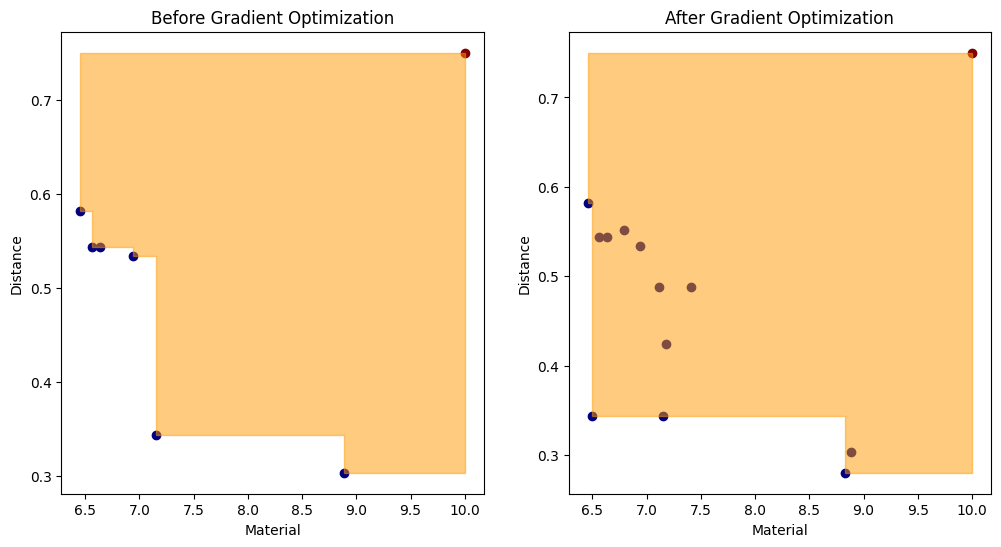

In [ ]:
plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Before Gradient Optimization')
ga_visualizer.plot_HV(F_before, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

plt.subplot(1, 2, 2)
plt.title('After Gradient Optimization')
ga_visualizer.plot_HV(F, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

A small improvement. But this is just to give you an idea of what you can do when mixing optimization methods.

Now you should have a good idea of how to use the tools we have provided to you. Think about how you can improve each aspect of the optimization to achieve a higher score in you final submission. You are allowed also submit your teams best solutions to the leaderboard which we will announce soon and see how well you are doing compared other teams.

A few hints and ideas:
- Why not do some preprocessing to random mechanisms before running GA?
- Can you use the gradients of both functions in gradient based optimization? 
- Can you cycle through multiple optimization runs?
- Can you mix different kinds of GA? We showed how GA can be used for a single mechanism skeleton and how it can be used to also create the mechanisms?
- Can you modify the GA mutations and cross-over?
- Is there a more efficient representation of mechanisms we can use?
- Are there smarter gradient-based optimization methods?